In [2]:
from diskcache import Cache
import os
from Utils.data_manager import DataManager
from Utils.models import FLNet
from Clients.training import Training
import copy
import torch
from torch import nn
from Utils.analytics import Analytics
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class FULDebug:
    def __init__(self, cache, breakpoint, num_parties, num_fl_rounds):
        
        cache["breakpoint"] = breakpoint
        self.num_parties = num_parties
        self.num_fl_rounds = num_fl_rounds
        self.cache = cache
    
    def average_selected_models(self, selected_parties, party_models):
        with torch.no_grad():
            sum_vec = nn.utils.parameters_to_vector(party_models[selected_parties[0]].parameters())
            if len(selected_parties) > 1:
                for i in range(1,len(selected_parties)):
                    sum_vec += nn.utils.parameters_to_vector(party_models[selected_parties[i]].parameters())
                sum_vec /= len(selected_parties)

            model = copy.deepcopy(party_models[0])
            nn.utils.vector_to_parameters(sum_vec, model.parameters())
        return model.state_dict()
    
    def aggregate(self, client_models, current_model=None):
        selected_parties = [i for i in range(self.num_parties)]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict 
    
    def partiesStart(self, trainloader_lst, testloader, client_to_be_erased=100, dataType="FMNIST"):

        num_fl_rounds = self.num_fl_rounds
        num_parties = self.num_parties
        initial_model = FLNet()
        model_dict = copy.deepcopy(initial_model.state_dict())
        for round_num in range(num_fl_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(FLNet())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType=dataType)

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.aggregate(client_models=client_models, current_model=current_model)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FLNet()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            # clean_accuracy[fusion_key][round_num] = clean_acc        
            self.cache[f"client_models"] = client_models
            self.cache[f"global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            # print(self.cache.get(f"client_models_{round_num}"))

    # Function to compute class-wise accuracy
    def compute_classwise_metrics(self, model, test_loader):
        class_correct = defaultdict(int)
        class_total = defaultdict(int)
        
        model.eval()
        
        with torch.no_grad():
            for data, labels in test_loader:
                if data.dim() == 5:  # If the image has an extra dimension, squeeze it
                    data = data.squeeze(1)  # Remove the extra dimension
                    
                # Check if the input tensor has the correct shape for CIFAR-10
                if data.shape[1] == 32:  # Indicates the channel dimension is incorrectly set as 32
                    # Permute from [batch_size, height, width, channels] to [batch_size, channels, height, width]
                    data = data.permute(0, 3, 1, 2)
                    
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                
                # Update class-wise correct/total counts
                for label, prediction in zip(labels, predicted):
                    class_total[label.item()] += 1
                    if label.item() == prediction.item():
                        class_correct[label.item()] += 1
        
        # Compute class-wise accuracies
        class_accuracies = {cls: class_correct[cls] / class_total[cls] if class_total[cls] > 0 else 0
                            for cls in class_total}
        
        return class_accuracies, class_total

    # Function to identify classes impacted by unlearning
    def identify_affected_classes(self, global_model_before, global_model_after, test_loader, threshold=0.05):
        """
        Identify the classes that are significantly impacted after unlearning client 0.
        
        :param global_model_before: The global model before unlearning.
        :param global_model_after: The global model after unlearning.
        :param test_loader: The test data loader.
        :param threshold: The threshold to consider a class significantly impacted.
        :return: A list of impacted classes.
        """
        # Compute class-wise accuracy before and after unlearning
        before_class_accuracies, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        after_class_accuracies, _ = self.compute_classwise_metrics(global_model_after, test_loader)
    
        impacted_classes = []
    
        # Compare class accuracies before and after unlearning
        for cls in before_class_accuracies:
            accuracy_drop = before_class_accuracies[cls] - after_class_accuracies[cls]
            if accuracy_drop > threshold:
                impacted_classes.append(cls)
    
        return impacted_classes

    def calculate_class_weights(self, global_model_before, global_model_after, test_loader, impacted_classes):
        """
        Calculate class weights based on the accuracy difference before and after unlearning.
        
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param test_loader: DataLoader for the test data.
        :param impacted_classes: List of impacted classes.
        :return: Dictionary with class indices as keys and weights as values.
        """
        # Compute class-wise accuracies before and after unlearning
        class_accuracies_before, _ = self.compute_classwise_metrics(global_model_before, test_loader)
        class_accuracies_after, _ = self.compute_classwise_metrics(global_model_after, test_loader)
        
        # Calculate the absolute difference in accuracy for each impacted class
        accuracy_diffs = {class_idx: abs(class_accuracies_before[class_idx] - class_accuracies_after[class_idx])
                          for class_idx in impacted_classes}
        
        # Normalize the differences to sum to 1 (to be used as weights)
        total_diff = sum(accuracy_diffs.values())
        class_weights = {class_idx: (diff / total_diff) for class_idx, diff in accuracy_diffs.items()} if total_diff > 0 else {class_idx: 1/len(impacted_classes) for class_idx in impacted_classes}
        
        # Print class weights for reference
        for class_idx, weight in class_weights.items():
            print(f"Class {class_idx} Weight: {weight:.4f}")
        
        return class_weights

    
    def select_clients_to_fix_bias(self, clients_models, impacted_classes, test_loader, global_model, global_model_before, global_model_after, num_clients=3, lambda_penalty=0.1):
        """
        Select clients that contribute the most to the affected classes with automated class weighting and regularization.
        
        :param clients_models: List of models for remaining clients.
        :param impacted_classes: List of classes impacted by unlearning client 0.
        :param test_loader: DataLoader for the test data.
        :param global_model: Global model to compute deviations for regularization.
        :param global_model_before: Global model before unlearning.
        :param global_model_after: Global model after unlearning.
        :param num_clients: Number of clients to select for fixing the bias.
        :param lambda_penalty: Regularization term to penalize clients with large deviations from global performance.
        :return: Tuple of (list of selected client indices, list of selected client models).
        """
        # Automatically assign class weights based on accuracy impact
        class_weights = self.calculate_class_weights(global_model_before, global_model_after, test_loader, impacted_classes)
    
        client_contributions = []
        
        # Compute global model's class-wise accuracy for regularization
        global_class_accuracies, _ = self.compute_classwise_metrics(global_model, test_loader)
        
        # Compute class-wise accuracy for each client
        for client_idx, client_model in enumerate(clients_models):
            class_accuracies, _ = self.compute_classwise_metrics(client_model, test_loader)
            
            # Calculate the weighted contribution of this client to the impacted classes
            contribution = sum((class_accuracies[class_idx] * class_weights[class_idx]) for class_idx in impacted_classes)
            
            # Compute the regularization term: deviation from the global model
            deviation_penalty = sum(abs(class_accuracies[class_idx] - global_class_accuracies[class_idx]) for class_idx in impacted_classes)
            
            # Final score: contribution minus regularization penalty
            final_contribution = contribution - lambda_penalty * deviation_penalty
            
            client_contributions.append((client_idx, client_model, final_contribution))
        
        # Sort clients by their final contribution score
        client_contributions.sort(key=lambda x: x[2], reverse=True)
        
        # Select top clients to fix the bias
        selected_clients = client_contributions[:num_clients]
        
        # Extract client indices and models for the selected clients
        selected_client_indices = [client_idx for client_idx, _, _ in selected_clients]
        selected_client_models = [client_model for _, client_model, _ in selected_clients]
        
        # Print selected clients and their contributions
        for client_idx, _, contribution in selected_clients:
            print(f"Selected Client {client_idx} with Contribution: {contribution:.4f}")
        
        # Return both selected client indices and models
        return selected_client_models, selected_client_indices


    def unlearnedModelAggregationWithSelectedClients(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100, select_clients_method='random', select_num_clients=6):
    
        num_parties = self.num_parties
        initial_model = FLNet()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())

        model_before = self.cache.get('initial_model')
        model_before.load_state_dict(self.cache.get('global_models'))
        model_before.eval()
        
        model_after = self.cache.get('initial_model')
        model_after.load_state_dict(self.cache.get("unlearned_model").state_dict())
        model_after.eval()
        
        client_model = self.cache.get('initial_model')
        client_model.load_state_dict(self.cache.get("client_models")[0].state_dict())
        client_model.eval()
        
        global_model_accuracies = []
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
    
            for party_id in range(num_parties):
                if party_id == client_to_be_erased:
                    client_models.append(FLNet())  # Placeholder for unlearned client
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                    trainloader=trainloader_lst[party_id], 
                                                    criterion=None, opt=None, dataType="CIFAR")
    
                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
    
            ###################### Client Selection ###############################
            impacted_classes = self.identify_affected_classes(model_before, model_after, testDataloader, threshold=0.05)
            selected_client_models, selected_client_indices = self.select_clients_to_fix_bias(client_models, impacted_classes, testDataloader, model_before, model_before, model_after, num_clients=5)
            print(selected_client_models)
    
            #######################################################################
            # Aggregate only the selected client models
            current_model_state_dict = self.unlearnAggregate(client_models=selected_client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FLNet()
            eval_model.load_state_dict(current_model_state_dict)
    
            clean_acc = local_training.evaluate(testloader, eval_model)
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')
            global_model_accuracies.append(clean_acc)
            self.cache[f"unlearning_client_models"] = client_models
            self.cache[f"unlearning_global_models"] = current_model_state_dict
        return global_model_accuracies
    
    def unlearnAggregate(self, client_models, client_to_be_erased):
        selected_parties = [i for i in range(len(client_models))]
        aggregated_model_state_dict = self.average_selected_models(selected_parties, client_models)
        return aggregated_model_state_dict
    
    def unlearnedModelAggregation(self, trainloader_lst, testloader, unlearned_model, num_rounds=10, client_to_be_erased=100):

        num_parties = self.num_parties
        initial_model = FLNet()
        current_model_state_dict = copy.deepcopy(unlearned_model.state_dict())  
        initial_model.load_state_dict(current_model_state_dict)  
        model_dict = copy.deepcopy(initial_model.state_dict())
        for round_num in range(num_rounds): 
            ##################### Local Training Round #############################
            current_model_state_dict = copy.deepcopy(model_dict)
            current_model = copy.deepcopy(initial_model)
            current_model.load_state_dict(current_model_state_dict)
            client_models = []
            party_losses = []
            for party_id in range(num_parties):

                if party_id == client_to_be_erased:
                    client_models.append(FLNet())
                else:
                    model = copy.deepcopy(current_model)
                    local_training = Training(num_updates_in_epoch=None, num_local_epochs=1)
                    model_update, party_loss = local_training.train(model=model, 
                                                trainloader=trainloader_lst[party_id], 
                                                criterion=None, opt=None, dataType="FMNIST")

                    client_models.append(copy.deepcopy(model_update))
                    party_losses.append(party_loss)
                    print(f"Party {party_id} Loss: {party_loss}")
            ######################################################################  
            current_model_state_dict = self.unlearnAggregate(client_models=client_models, client_to_be_erased=client_to_be_erased)
            model_dict = copy.deepcopy(current_model_state_dict)
            eval_model = FLNet()
            eval_model.load_state_dict(current_model_state_dict)
            clean_acc = local_training.evaluate(testloader, eval_model)
            # clean_accuracy[fusion_key][round_num] = clean_acc      
            self.cache[f"unlearning_client_models"] = client_models
            self.cache[f"unlearning_global_models"] = current_model_state_dict
            print(f'Global Clean Accuracy, round {round_num} = {clean_acc}')

    def compute_weight_contribution(self, global_model, client_updates, selected_client_idx):
        """
        Compute the influence of each client's weight contribution to the global model.

        :param global_model: The baseline global model (PyTorch model)
        :param client_updates: List of model updates from each client (list of state_dicts)
        :param selected_client_idx: Index of the client whose contribution you want to analyze
        :return: Difference between the global model's weights with and without the selected client's contribution
        """
        # Compute the average weight update with all clients
        num_clients = len(client_updates)
        avg_update = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for update in client_updates:
            for key in update.state_dict():
                avg_update[key] += update.state_dict()[key] / num_clients

        # Compute the average weight update without the selected client
        avg_update_without_client = {key: torch.zeros_like(val) for key, val in client_updates[0].state_dict().items()}

        for i, update in enumerate(client_updates):
            if i == selected_client_idx:
                continue  # Skip the selected client
            for key in update.state_dict():
                avg_update_without_client[key] += update.state_dict()[key] / (num_clients - 1)

        # Calculate the difference in the global model's weights
        weight_difference = {key: avg_update[key] - avg_update_without_client[key] for key in avg_update}

        return weight_difference

    def compute_weight_norm_difference(self, weight_difference):
        """
        Computes the norm of the weight differences to quantify the impact.

        :param weight_difference: Dictionary containing weight differences for each layer
        :return: Dictionary with norms for each layer
        """
        norm_diff = {}
        for layer, diff in weight_difference.items():
            norm_diff[layer] = torch.norm(diff).item()
        return norm_diff
    
    def analyze_class_bias(self, global_model, weight_difference, num_classes=10):
        """
        Analyzes the class-specific impact of removing a client's weight contribution.

        :param global_model: The baseline global model (PyTorch model)
        :param weight_difference: Difference in weights with and without the selected client's contribution
        :param num_classes: Number of classes in the dataset (e.g., 10 for MNIST)
        :return: Impact on each class based on output layer weight differences
        """
        output_layer_key = None

        # Identify the output layer by checking for the appropriate layer name
        for key in weight_difference.keys():
            if 'weight' in key and weight_difference[key].shape[0] == num_classes:
                output_layer_key = key
                break

        if output_layer_key is None:
            raise ValueError("Could not identify the output layer in the model.")

        # Analyze the impact on each class
        class_impact = torch.norm(weight_difference[output_layer_key], dim=1).tolist()
        return class_impact

    def summarize_and_print_results(slef, norm_diff, class_impact):
        """
        Summarizes and prints the results of the weight differences and class impacts.

        :param norm_diff: Dictionary containing the norms of weight differences for each layer
        :param class_impact: List containing the impact on each class
        """
        print("=== Summary of Weight Differences by Layer ===")
        print(f"{'Layer':<20} {'Norm Difference':>20}")
        print("-" * 40)
        
        for layer, norm in norm_diff.items():
            print(f"{layer:<20} {norm:>20.6f}")
        
        print("\n=== Impact on Each Class ===")
        print(f"{'Class':<10} {'Impact':>10}")
        print("-" * 25)
        
        for class_idx, impact in enumerate(class_impact):
            print(f"Class {class_idx:<5} {impact:>10.6f}")
        
        print("\n=== Analysis ===")
        
        # Find the class with the maximum and minimum impact
        max_impact_class = max(range(len(class_impact)), key=lambda i: class_impact[i])
        min_impact_class = min(range(len(class_impact)), key=lambda i: class_impact[i])
        
        print(f"The highest impact is on Class {max_impact_class} with an impact value of {class_impact[max_impact_class]:.6f}.")
        print(f"The lowest impact is on Class {min_impact_class} with an impact value of {class_impact[min_impact_class]:.6f}.")

        # Determine which layers are most and least affected
        most_affected_layer = max(norm_diff, key=norm_diff.get)
        least_affected_layer = min(norm_diff, key=norm_diff.get)
        
        print(f"The most affected layer is '{most_affected_layer}' with a norm difference of {norm_diff[most_affected_layer]:.6f}.")
        print(f"The least affected layer is '{least_affected_layer}' with a norm difference of {norm_diff[least_affected_layer]:.6f}.")
        print("\nThis analysis suggests that removing the selected client's contribution mainly affects the above class and layer.")



In [4]:
# Initialize the cache
cache = Cache('./cache1', size_limit=5 * 10**9)
initial_model = FLNet()
cache["initial_model"] = initial_model
breakpoint =  {"round": 5, "status": False}
# Initialize the MNIST loader
loader = DataManager(download_dir="./data", normalize=True)
# Load the MNIST data
(x_train, y_train), (x_test, y_test) = loader.load_mnist()
dataLoader = loader.split_data_uneven(x_train, y_train)
# dataLoader = loader.split_data_label_flipping(x_train, y_train)
testDataloader = loader.get_test_dataloader(x_test, y_test)
print(testDataloader)

In [5]:
parties = 10
sim = FULDebug(cache, breakpoint, parties, 10)
sim.partiesStart(dataLoader, testDataloader)

Party 0 Loss: 1.1689526353563582
Party 1 Loss: 2.02873018447389
Party 2 Loss: 2.0252574555417326
Party 3 Loss: 2.0338957650320872
Party 4 Loss: 2.032106331416539
Party 5 Loss: 2.0246132896060036
Party 6 Loss: 2.0333139782860163
Party 7 Loss: 2.0216374681109475
Party 8 Loss: 2.0342685182889304
Party 9 Loss: 2.0280576887584867
Global Clean Accuracy, round 0 = 64.45
Party 0 Loss: 0.5553600713610649
Party 1 Loss: 0.7325944881489936
Party 2 Loss: 0.7590568636326079
Party 3 Loss: 0.7435601154963175
Party 4 Loss: 0.7071980280535561
Party 5 Loss: 0.724790307027953
Party 6 Loss: 0.7096217331432161
Party 7 Loss: 0.7307565999882562
Party 8 Loss: 0.7547762202365058
Party 9 Loss: 0.7222093017328353
Global Clean Accuracy, round 1 = 83.09
Party 0 Loss: 0.2789180457059826
Party 1 Loss: 0.3605110315566367
Party 2 Loss: 0.39488716201579316
Party 3 Loss: 0.38993045687675476
Party 4 Loss: 0.3740004929048674
Party 5 Loss: 0.3826459756209737
Party 6 Loss: 0.36122084267082666
Party 7 Loss: 0.3641454084288506

In [7]:
from Ful_Algo.ibm_ful import IBMFUL
%load_ext autoreload
%autoreload 2
# Usage example
unlearning_instance = IBMFUL(
    client_models=cache.get("client_models"),
    global_model=cache.get("global_models"),
    num_parties=10,  # Example value
    party_to_be_erased=0,  # Example value
    trainloader_lst=dataLoader,
    testloader=testDataloader,
    testloader_poison=dataLoader,
    initial_model=FLNet(),
    lr=0.01,
    num_local_epochs_unlearn=5,
    distance_threshold=0.3,
    clip_grad=5
)

unlearned_model = unlearning_instance.execute_unlearning()
cache["unlearned_model"] = unlearned_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Mean distance of Reference Model to random: 443.19891357421875
Radius for model_ref: 147.73297119140625
------------ 0
Distance from the unlearned model to party to be erased: 0.23381870985031128
Distance from the unlearned model to party to be erased: 0.27748435735702515
Distance from the unlearned model to party to be erased: 0.3672550916671753
Clean Accuracy for UN-Local Model = 81.98


In [8]:
sim = FULDebug(cache, breakpoint, parties, 10)
sim.unlearnedModelAggregation(dataLoader, testDataloader, unlearned_model, num_rounds=5, client_to_be_erased=0)

Party 1 Loss: 0.21175346063806655
Party 2 Loss: 0.22336657448334896
Party 3 Loss: 0.13417928816661948
Party 4 Loss: 0.13036463338704335
Party 5 Loss: 0.13053683741461664
Party 6 Loss: 0.11399914244455951
Party 7 Loss: 0.12484978361143953
Party 8 Loss: 0.12133483659653437
Party 9 Loss: 0.11851966185938745
Global Clean Accuracy, round 0 = 94.95
Party 1 Loss: 0.11933805111874925
Party 2 Loss: 0.1305614620288636
Party 3 Loss: 0.11119401880673
Party 4 Loss: 0.1185521169432572
Party 5 Loss: 0.12080912859666915
Party 6 Loss: 0.11449195533281281
Party 7 Loss: 0.11435536995884918
Party 8 Loss: 0.11449777813894409
Party 9 Loss: 0.11235753349250271
Global Clean Accuracy, round 1 = 95.47
Party 1 Loss: 0.12238899214153594
Party 2 Loss: 0.1451090064613109
Party 3 Loss: 0.12745135596820287
Party 4 Loss: 0.12489891132073742
Party 5 Loss: 0.13454711508183254
Party 6 Loss: 0.1214297345529
Party 7 Loss: 0.1248395803074042
Party 8 Loss: 0.13032614670339085
Party 9 Loss: 0.1252092200198344
Global Clean Acc

In [9]:
sim = FULDebug(cache, breakpoint, parties, 10)
global_model_accuracies_with_FULDebug = sim.unlearnedModelAggregationWithSelectedClients(dataLoader, testDataloader, unlearned_model, num_rounds=5, client_to_be_erased=0)

Party 1 Loss: 0.2211021261408608
Party 2 Loss: 0.23533092787925233
Party 3 Loss: 0.13613368260363737
Party 4 Loss: 0.13125293684147654
Party 5 Loss: 0.12797309023638567
Party 6 Loss: 0.10987490867929799
Party 7 Loss: 0.13446607112529732
Party 8 Loss: 0.12766330618233906
Party 9 Loss: 0.12279398579682622
Class 7 Weight: 0.1050
Class 2 Weight: 0.0754
Class 1 Weight: 0.7139
Class 5 Weight: 0.0601
Class 3 Weight: 0.0456
Selected Client 1 with Contribution: 0.9700
Selected Client 2 with Contribution: 0.9665
Selected Client 3 with Contribution: 0.1905
Selected Client 7 with Contribution: 0.1865
Selected Client 8 with Contribution: 0.1838
[FLNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
), FLNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), paddi

In [10]:
%load_ext autoreload
%autoreload 2

analytics = Analytics(cache)
analytics.client_vs_global_per_class_accuracy(0, testDataloader)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
### Client {client_idx} vs Global Model Per Class Accuracy ###
Client Model Accuracy = 96.89%, Global Model Before Accuracy = 97.02%
Class 0: Client Model Accuracy = 98.88%, Global Model Before Accuracy = 98.98%
Class 1: Client Model Accuracy = 99.56%, Global Model Before Accuracy = 94.54%
Class 2: Client Model Accuracy = 95.25%, Global Model Before Accuracy = 97.09%
Class 3: Client Model Accuracy = 96.63%, Global Model Before Accuracy = 97.62%
Class 4: Client Model Accuracy = 96.23%, Global Model Before Accuracy = 98.07%
Class 5: Client Model Accuracy = 97.65%, Global Model Before Accuracy = 97.31%
Class 6: Client Model Accuracy = 96.97%, Global Model Before Accuracy = 97.91%
Class 7: Client Model Accuracy = 97.57%, Global Model Before Accuracy = 96.79%
Class 8: Client Model Accuracy = 93.33%, Global Model Before Accuracy = 96.10%
Class 9: Client Model Accuracy = 96.53%, Global Model Before Accurac

In [11]:
analytics.unlearned_model_vs_global_per_class_accuracy(testDataloader)

### Unlearned vs Global Model Per Class Accuracy ###
Unlearned Model Accuracy = 81.98%, Global Model Before Accuracy = 97.02%
Class 0: Global Model Before = 98.98%, After = 98.27%, Δ = -0.71%
Class 1: Global Model Before = 94.54%, After = 0.00%, Δ = -94.54%
Class 2: Global Model Before = 97.09%, After = 87.11%, Δ = -9.98%
Class 3: Global Model Before = 97.62%, After = 91.58%, Δ = -6.04%
Class 4: Global Model Before = 98.07%, After = 95.01%, Δ = -3.05%
Class 5: Global Model Before = 97.31%, After = 89.35%, Δ = -7.96%
Class 6: Global Model Before = 97.91%, After = 94.89%, Δ = -3.03%
Class 7: Global Model Before = 96.79%, After = 82.88%, Δ = -13.91%
Class 8: Global Model Before = 96.10%, After = 99.69%, Δ = 3.59%
Class 9: Global Model Before = 96.23%, After = 94.05%, Δ = -2.18%
######


In [12]:
analytics.global_before_vs_global_after_per_class_accuracy(testDataloader)


### Unlearned vs Global Model Per Class Accuracy ###
Global Model After Accuracy = 97.81%, Global Model Before Accuracy = 97.02%
Class 0: Global Model Before = 98.98%, After = 99.29%, Δ = 0.31%
Class 1: Global Model Before = 94.54%, After = 96.30%, Δ = 1.76%
Class 2: Global Model Before = 97.09%, After = 98.45%, Δ = 1.36%
Class 3: Global Model Before = 97.62%, After = 97.52%, Δ = -0.10%
Class 4: Global Model Before = 98.07%, After = 98.68%, Δ = 0.61%
Class 5: Global Model Before = 97.31%, After = 98.54%, Δ = 1.23%
Class 6: Global Model Before = 97.91%, After = 98.02%, Δ = 0.10%
Class 7: Global Model Before = 96.79%, After = 96.79%, Δ = 0.00%
Class 8: Global Model Before = 96.10%, After = 97.54%, Δ = 1.44%
Class 9: Global Model Before = 96.23%, After = 97.32%, Δ = 1.09%
######


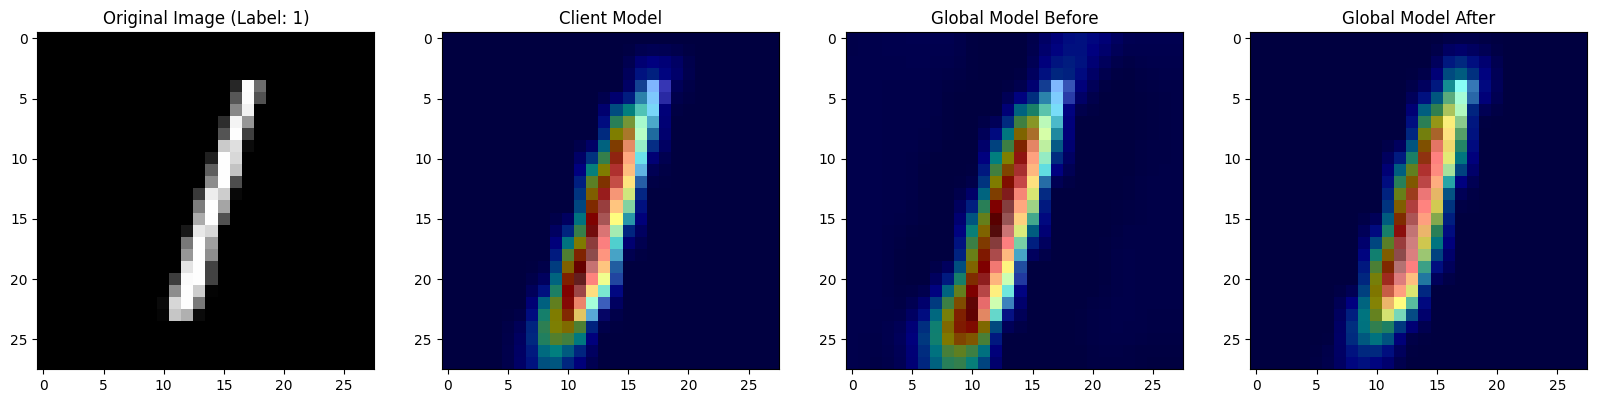

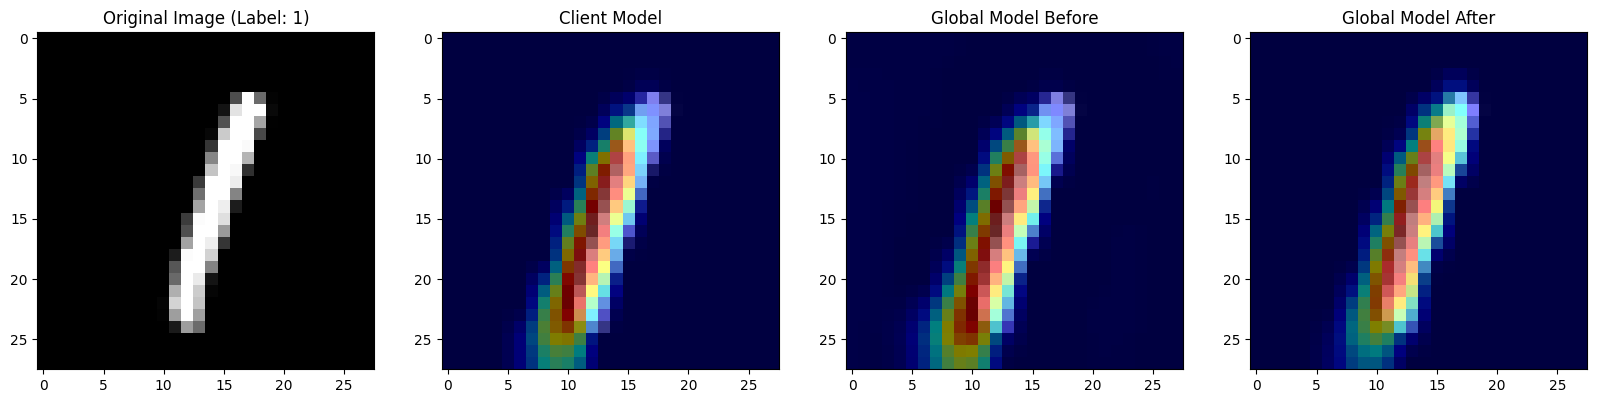

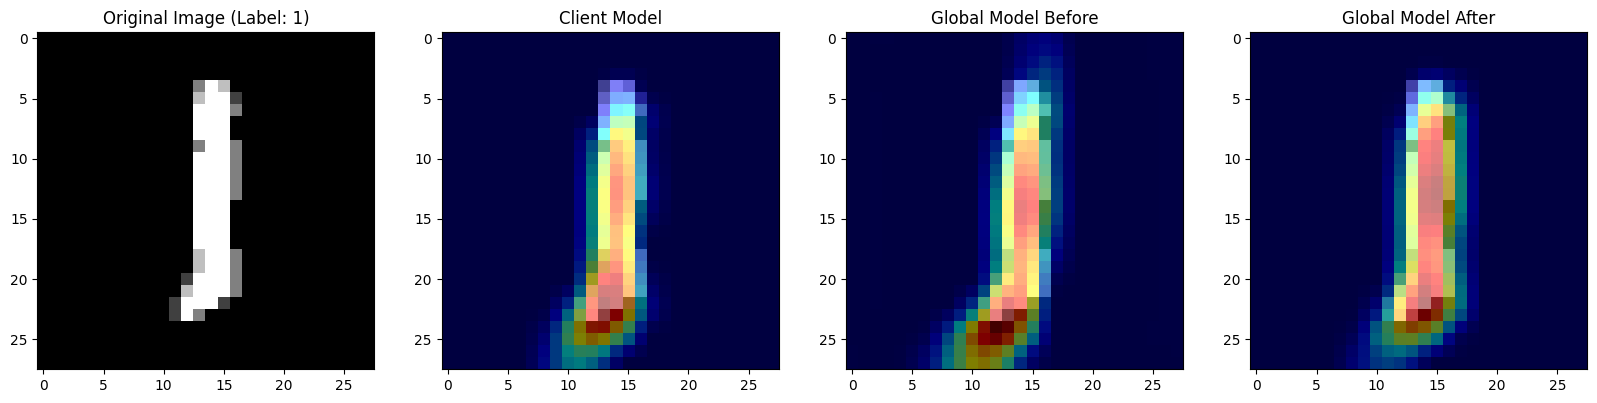

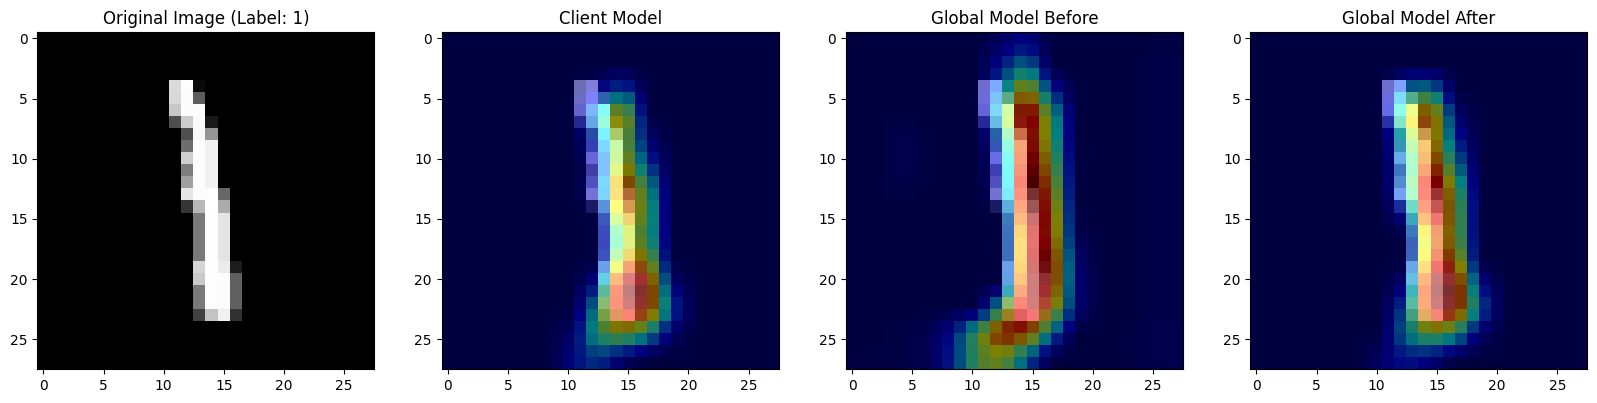

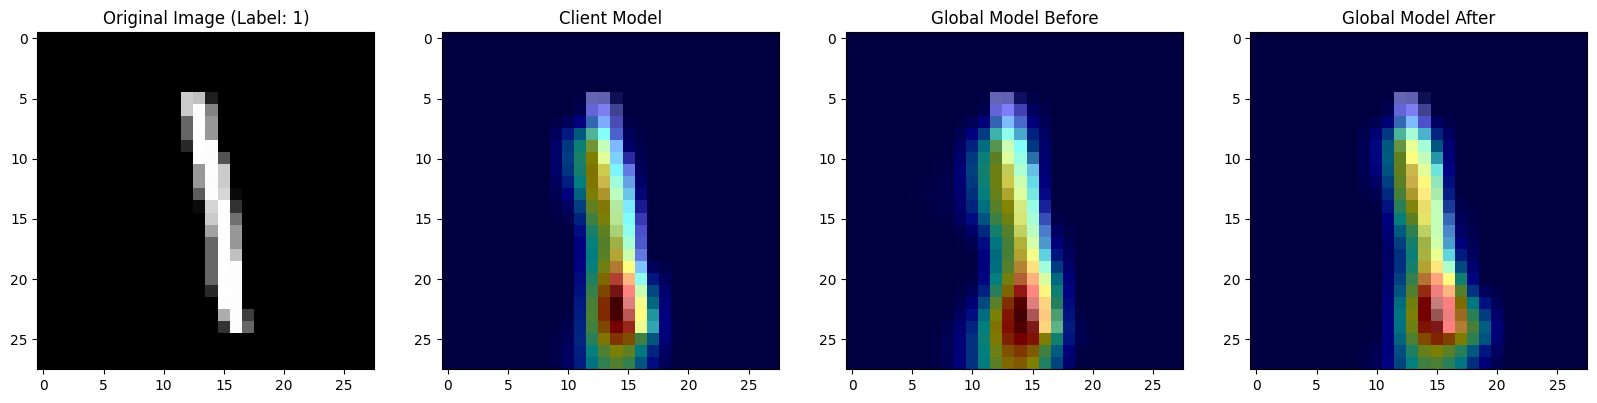

In [13]:
analytics.visualize_feature_comparison(client_idx=0, testDataloader=testDataloader, num_images_to_visualize=5, visualization_class=1)

In [14]:
analytics.display_classwise_metrics(0, testDataloader)


Class 0:
  Accuracy:
    Client Model:      |||||||||||||||||||||||||||||| (0.99)
    Global Before:     |||||||||||||||||||||||||||||| (0.99)
    Global After:      |||||||||||||||||||||||||||||| (0.99)
  Confidence:
    Client Model:      |||||||||||||||||||||||||||||- (0.98)
    Global Before:     |||||||||||||||||||||||||||||| (0.98)
    Global After:      |||||||||||||||||||||||||||||| (0.99)
---

Class 1:
  Accuracy:
    Client Model:      |||||||||||||||||||||||||||||| (1.00)
    Global Before:     ||||||||||||||||||||||||||||-- (0.95)
    Global After:      |||||||||||||||||||||||||||||- (0.96)
  Confidence:
    Client Model:      |||||||||||||||||||||||||||||| (0.99)
    Global Before:     |||||||||||||||||||||||||----- (0.84)
    Global After:      |||||||||||||||||||||||||||--- (0.91)
---

Class 2:
  Accuracy:
    Client Model:      |||||||||||||||||||||||||||||- (0.95)
    Global Before:     |||||||||||||||||||||||||||||- (0.97)
    Global After:      |||||||||||||||||||||

In [15]:
analytics.display_feature_summary(0, testDataloader)


Class 0:
Client Model 0:                  |||||||||||||||||------------- (0.0111)
Global Model Before Unlearning:  ||||||||||||||||||||---------- (0.0129)
Global Model After Unlearning:   |||||||||||||||||||----------- (0.0123)

Class 1:
Client Model 0:                  |||||||||||||||--------------- (0.0098)
Global Model Before Unlearning:  ||||||||||||||---------------- (0.0093)
Global Model After Unlearning:   |||||||||||||||--------------- (0.0094)

Class 2:
Client Model 0:                  ||||||||||||||---------------- (0.0087)
Global Model Before Unlearning:  ||||||||||||||||-------------- (0.0101)
Global Model After Unlearning:   ||||||||||||||||||------------ (0.0113)

Class 3:
Client Model 0:                  ||||||||||||||||-------------- (0.0103)
Global Model Before Unlearning:  ||||||||||||||||||||---------- (0.0127)
Global Model After Unlearning:   ||||||||||||||||||||---------- (0.0129)

Class 4:
Client Model 0:                  |||||||||||||||||||||||||----- (0.0162)
G

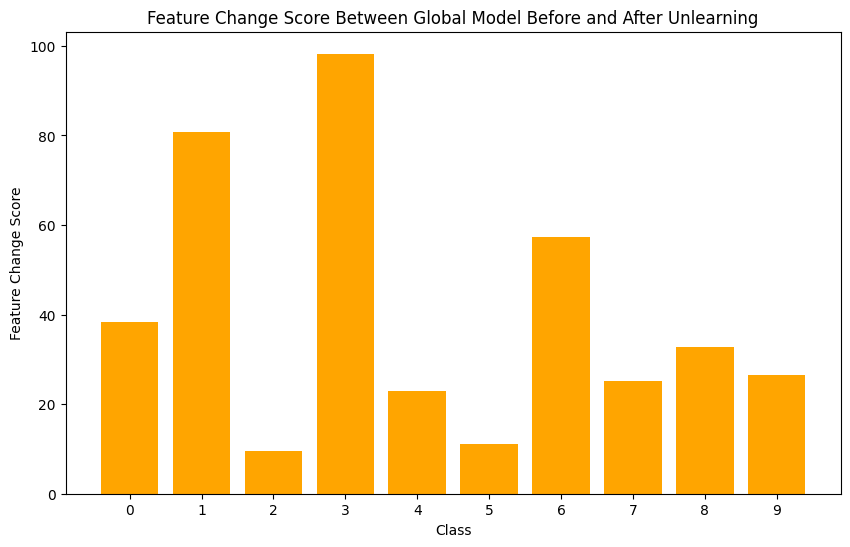

In [18]:
analytics.visualize_feature_change_class_wise_shared_unlearned_model(client_idx=0, testDataloader=testDataloader)

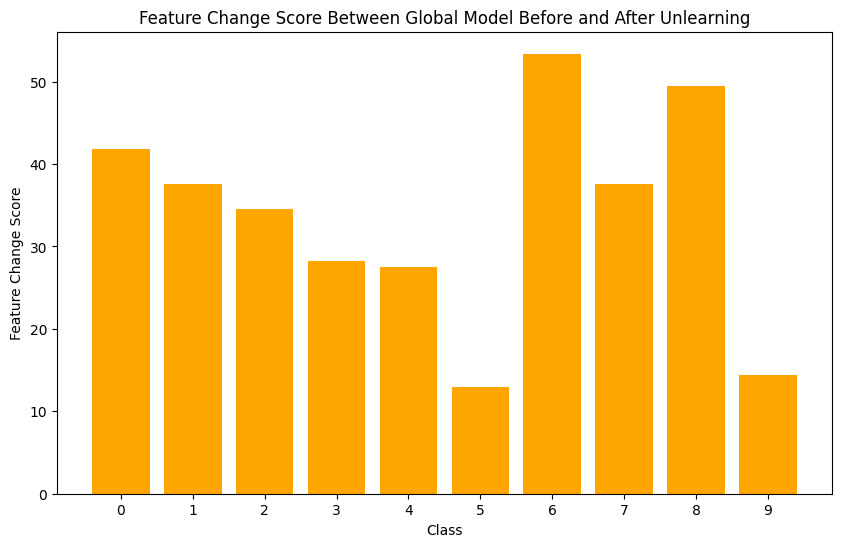

In [19]:
analytics.visualize_feature_change_class_wise(client_idx=0, testDataloader=testDataloader)

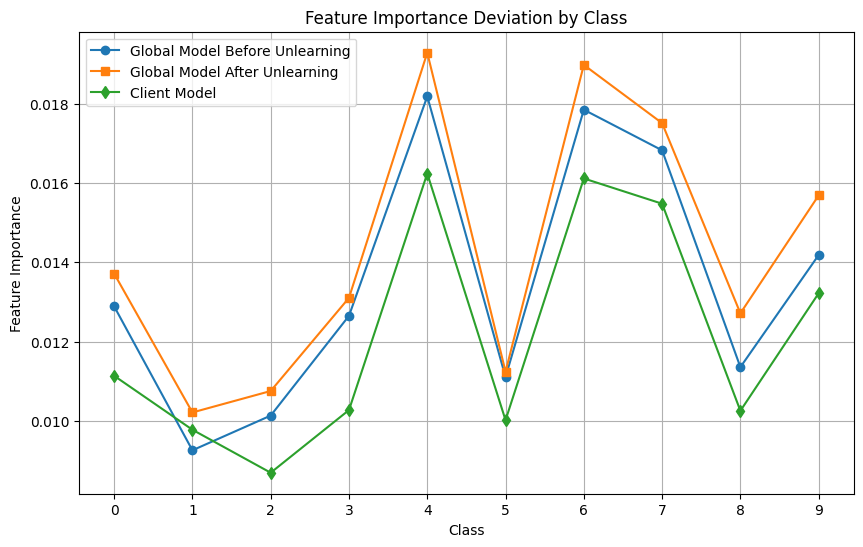

In [20]:
analytics.plot_mean_feature_deviation(client_idx=0, test_loader=testDataloader)